In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from graphframes import GraphFrame
import os

spark = SparkSession.builder.appName("graphs")\
        .config('spark.jars.packages', 'io.graphframes:graphframes-spark4_2.13:0.10.0')\
        .master("local[*]")\
        .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/15 19:24:36 WARN Utils: Your hostname, Thuy-Trangs-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 10.146.116.1 instead (on interface en0)
26/01/15 19:24:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/Users/thuytrangskalska/anaconda3/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /Users/thuytrangskalska/.ivy2.5.2/cache
The jars for the packages stored in: /Users/thuytrangskalska/.ivy2.5.2/jars
io.graphframes#graphframes-spark4_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-30058129-d5e8-4a7e-94c0-dd9261a1fb73;1.0
	confs: [default]
	found io.graphframes#graphframes-spark4_2.13;0.10.0 in central
	found io.graphframes#graphframes-graphx-spark4_2.13;0.10.0 in central
:: resolution report :: resol

In [2]:
# File location and type
file_location = "data/users_age.txt"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df_users = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

df_users.show()

+---+-------------+---------------+---+
| id|        login|           name|age|
+---+-------------+---------------+---+
|  1|  BarackObama|   Barack Obama| 60|
|  2|     ladygaga|Goddess of Love| 55|
|  3|      jeresig|     John Resig| 34|
|  4| justinbieber|  Justin Bieber| 32|
|  6|matei_zaharia|  Matei Zaharia| 45|
|  7|      odersky| Martin Odersky| 56|
|  8|      anonsys|      Anonymous| 70|
+---+-------------+---------------+---+



In [3]:
# File location and type
file_location = "data/followers2.txt"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = " "

# The applied options are for CSV files. For other file types, these will be ignored.
df_fol = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

df_fol = df_fol.withColumnRenamed('_c0', 'src')
df_fol = df_fol.withColumnRenamed('_c1', 'dst')

df_fol.show()

+---+---+
|src|dst|
+---+---+
|  2|  1|
|  4|  1|
|  1|  2|
|  6|  3|
|  7|  3|
|  7|  6|
|  6|  7|
|  3|  7|
|  3|  1|
|  4|  3|
+---+---+



In [4]:
from graphframes import GraphFrame

g = GraphFrame(df_users, df_fol)
#display(g)
#g.edges.show()
#g.vertices.show()
#
g.inDegrees.show()

+---+--------+
| id|inDegree|
+---+--------+
|  7|       2|
|  3|       3|
|  6|       1|
|  1|       3|
|  2|       1|
+---+--------+



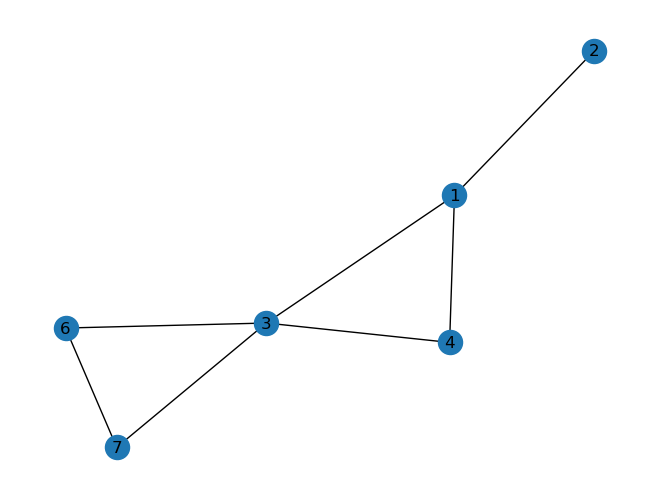

In [5]:
import networkx as nx

graph_pandas = g.edges.toPandas()
nxg = nx.from_pandas_edgelist(graph_pandas, 'src', 'dst')
nx.draw(nxg, with_labels=True)

In [6]:
my_edges = [ (r.src, r.dst) for r in df_fol.collect()]
print(my_edges)

[('2', '1'), ('4', '1'), ('1', '2'), ('6', '3'), ('7', '3'), ('7', '6'), ('6', '7'), ('3', '7'), ('3', '1'), ('4', '3')]


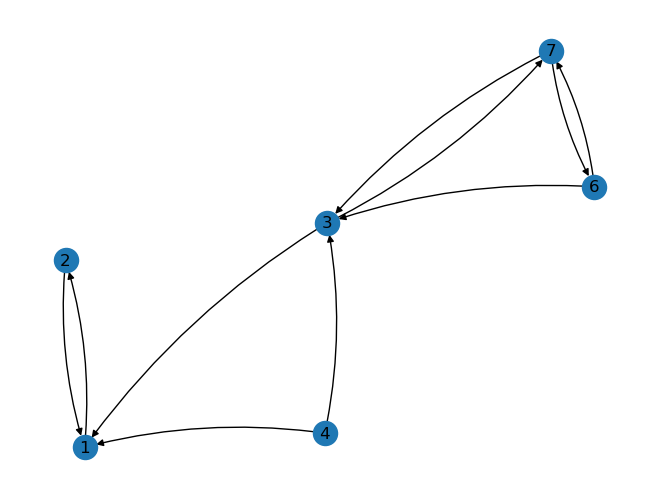

In [7]:
nxdg = nx.MultiDiGraph()
nxdg.add_edges_from(my_edges)
nx.draw(nxdg, with_labels=True, connectionstyle='arc3, rad=0.1')

In [8]:
pip install pyvis

Note: you may need to restart the kernel to use updated packages.


In [9]:
from pyvis.network import Network
from IPython.display import HTML

nt = Network(notebook=True, directed=True)
nt.from_nx(nxdg)
nt.prep_notebook()
#nt.generate_html()
HTML(nt.generate_html())
#display(HTML(nt.generate_html()))

In [11]:
results = g.shortestPaths(landmarks=[7])
#results = g.shortestPaths(landmarks=['Barack Obama', 'Justin Bieber'])
#results
results.show()

+---+-------------+---------------+---+---------+
| id|        login|           name|age|distances|
+---+-------------+---------------+---+---------+
|  4| justinbieber|  Justin Bieber| 32| {7 -> 2}|
|  1|  BarackObama|   Barack Obama| 60|       {}|
|  6|matei_zaharia|  Matei Zaharia| 45| {7 -> 1}|
|  3|      jeresig|     John Resig| 34| {7 -> 1}|
|  7|      odersky| Martin Odersky| 56| {7 -> 0}|
|  8|      anonsys|      Anonymous| 70|       {}|
|  2|     ladygaga|Goddess of Love| 55|       {}|
+---+-------------+---------------+---+---------+



26/01/15 19:26:46 WARN ShortestPaths: Returned DataFrame is persistent and materialized!
